<h1>Lab7</h1>

<h2><b>Fourier transform</b></h2>

<h3>Load modules</h3>

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.fftpack as fp
from scipy import signal

<h3>RGB to Gray function define</h3>

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

<h3>Pad with zeros function define</h3>

In [4]:
def padwithzeros(vector, pad_width, iaxis, kwargs):
    vector[:pad_width[0]] = 0
    vector[-pad_width[1]:] = 0
    return vector

<h2>Fourier Transform in Numpy</h2>

First we will see how to find Fourier Transform using Numpy. Numpy has an FFT package to do this. <b>np.fft.fft2()</b> provides us the frequency transform which will be a complex array. Its first argument is the input image, which is grayscale. Second argument is optional which decides the size of output array. If it is greater than size of input image, input image is padded with zeros before calculation of FFT. If it is less than input image, input image will be cropped. If no arguments passed, Output array size will be same as input.

Now once you got the result, zero frequency component (DC component) will be at top left corner. If you want to bring it to center, you need to shift the result by N/2 in both the directions. This is simply done by the function, <b>np.fft.fftshift()</b>. (It is more easier to analyze). Once you found the frequency transform, you can find the magnitude spectrum.

<h3>Read sample image</h3>

In [5]:
img = cv2.imread("./examples/Fig0429a.tif",0)

<h3>FFT</h3>

In [6]:
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

<h3>Plot input sample image and FFT result</h3>

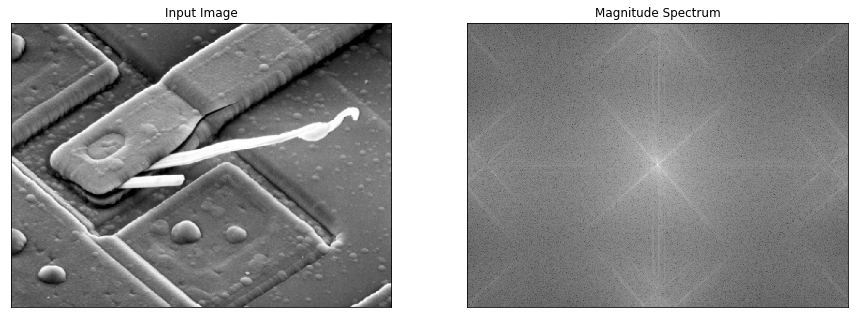

In [7]:
plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

See, You can see more whiter region at the center showing low frequency content is more.

So you found the frequency transform Now you can do some operations in frequency domain, like high pass filtering and reconstruct the image, ie find inverse DFT. For that you simply remove the low frequencies by masking with a rectangular window of size 60x60. Then apply the inverse shift using <b>np.fft.ifftshift()</b> so that DC component again come at the top-left corner. Then find inverse FFT using <b>np.ifft2()</b> function. The result, again, will be a complex number. You can take its absolute value.

<h3>High pass filter applying</h3>

In [8]:
rows, cols = img.shape
crow,ccol = rows/2 , cols/2
fshift[int(crow-30):int(crow+30), int(ccol-30):int(ccol+30)] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

<h3>Plot input sample image and image after HPF</h3>

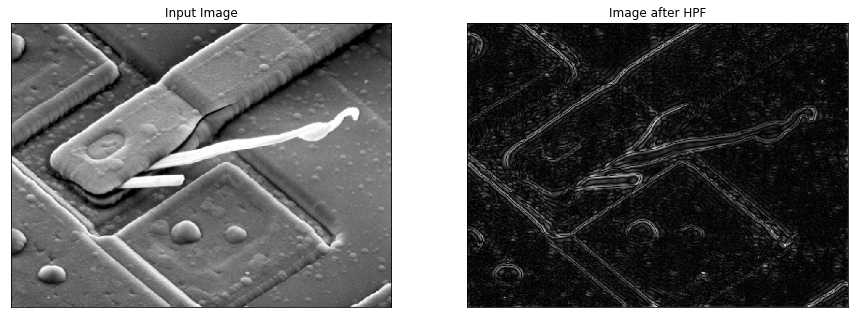

In [9]:
plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.show()

<h2>Fourier Transform in OpenCV</h2>

OpenCV provides the functions <b>cv2.dft()</b> and <b>cv2.idft()</b> for this. It returns the same result as previous, but with two channels. First channel will have the real part of the result and second channel will have the imaginary part of the result. The input image should be converted to np.float32 first.

In [10]:
dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

<h3>Plot input sample image and FFT result</h3>

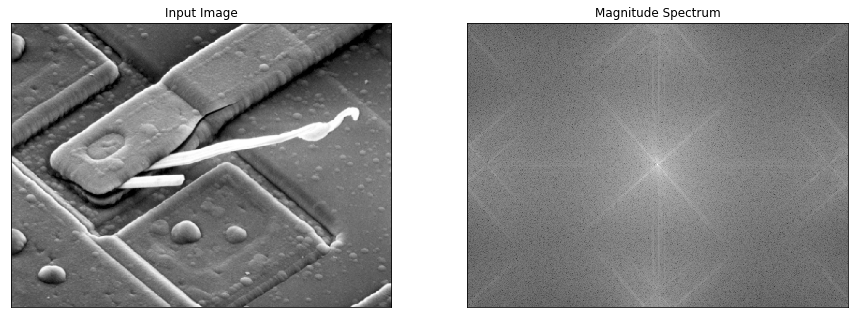

In [11]:
plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

So, now we have to do inverse DFT. In previous session, we created a HPF, this time we will see how to remove high frequency contents in the image, ie we apply LPF to image. It actually blurs the image. For this, we create a mask first with high value (1) at low frequencies, ie we pass the LF content, and 0 at HF region.

In [12]:
rows, cols = img.shape
crow,ccol = rows/2 , cols/2

<h3>Create a mask first, center square is 1, remaining all zeros</h3>

In [13]:
mask = np.zeros((rows,cols,2),np.uint8)
mask[int(crow-30):int(crow+30), int(ccol-30):int(ccol+30)] = 1

<h3>Apply mask and inverse DFT</h3>

In [14]:
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

<h3>Plot input sample image and image after LPF</h3>

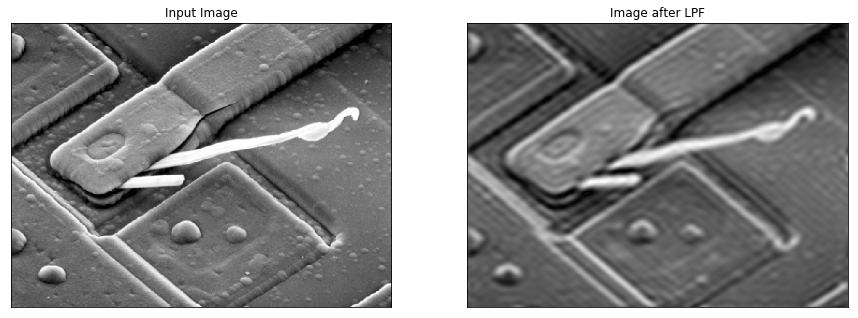

In [15]:
plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after LPF'), plt.xticks([]), plt.yticks([])
plt.show()

<h2>Down-sampling with anti-aliasing using Gaussian Filter</h2>

1. Start with a large gray-scale image and reduce the image size 16 times, by reducing both height and width by 4 times.
2. Select every 4th pixel in the x and the y direction from the original image to compute the values of the pixels in the smaller image.
3. Before down-sampling apply a Gaussian filter (to smooth the image) for anti-aliasing.
4. Compare the quality of the output image obtained by down-sampling without a Gaussian filter (with aliasing).

(678, 906)


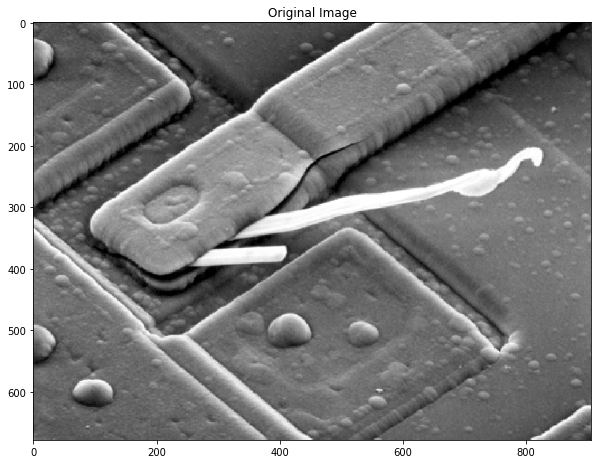

In [16]:
im = img
print(im.shape)
plt.figure(figsize=(10,10))
plt.imshow(im, cmap = 'gray'); plt.title('Original Image')
plt.show()

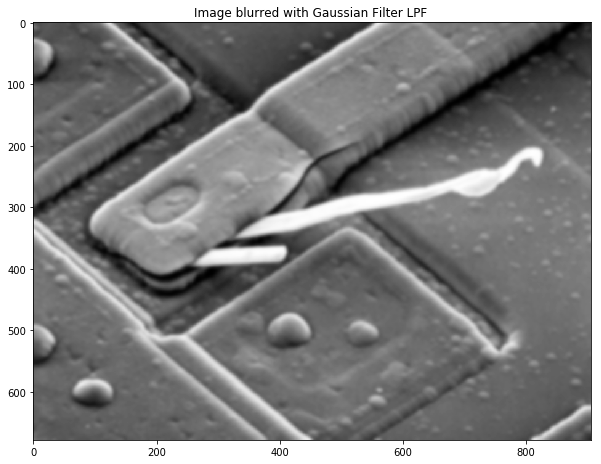

In [17]:
plt.figure(figsize=(10,10))
im_blurred = gaussian_filter(im, sigma=2.5) #(5,5,1)
plt.imshow(im_blurred, cmap = 'gray'); plt.title('Image blurred with Gaussian Filter LPF ')
plt.show()

In [18]:
n = 4 # create and image 16 times smaller in size
w, h = im.shape[0] // n, im.shape[1] // n
im_small = np.zeros((w,h))
for i in range(w):
   for j in range(h):
      im_small[i,j] = im[n*i, n*j]

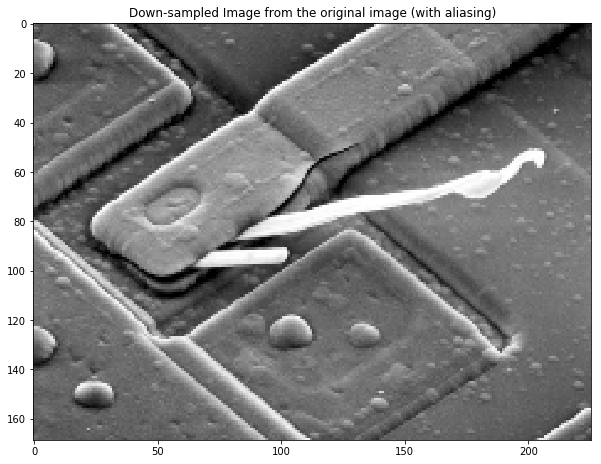

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(im_small, cmap = 'gray'); plt.title('Down-sampled Image from the original image (with aliasing)')
plt.show()

In [20]:
im_small = np.zeros((w,h))
for i in range(w):
   for j in range(h):
      im_small[i,j] = im_blurred[n*i, n*j]

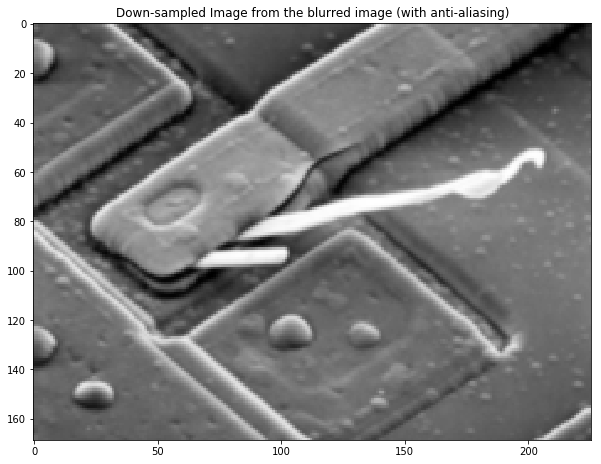

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(im_small, cmap = 'gray'); plt.title('Down-sampled Image from the blurred image (with anti-aliasing)')
plt.show()

<h2>Frequency Domain Gaussian Filter</h2>

1. Use an input image and use DFT to create the frequency 2D-array.
2. Create a small Gaussian 2D Kernel (to be used as an LPF) in the spatial domain and pad it to enlarge it to the image dimensions.
3. Use DFT to obtain the Gaussian Kernel in the frequency domain.
4. Use the Convolution theorem to convolve the LPF with the input image in the frequency domain.
5. Use IDFT to obtain the output image.
6. Plot the frequency spectrum of the image, the gaussian kernel and the image obtained after convolution in the frequency domain, in 3D.

In [24]:
kernel = np.outer(signal.gaussian(im.shape[0], 5), signal.gaussian(im.shape[1], 5))
freq = fp.fft2(im)
assert(freq.shape == kernel.shape)
freq_kernel = fp.fft2(fp.ifftshift(kernel))
convolved = freq*freq_kernel # by the Convolution theorem
im_blur = fp.ifft2(convolved).real
im_blur = 255 * im_blur / np.max(im_blur)

<h3>Plot original Image and Blurred Image</h3>

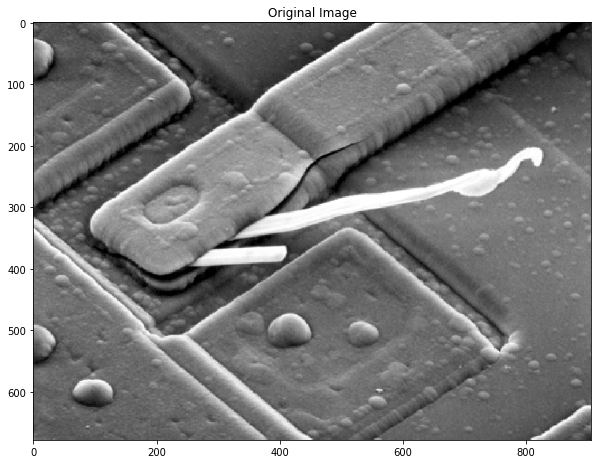

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(im, cmap = 'gray'); plt.title('Original Image')
plt.show()

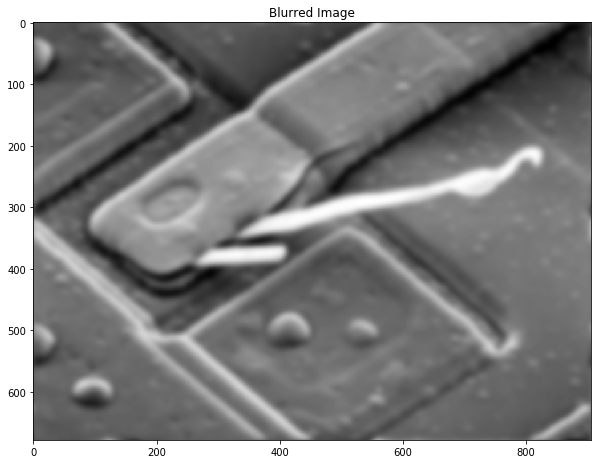

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(im_blur, cmap='gray'); plt.title('Blurred Image')
plt.show()

<h2>Using DFT to up-sample an image</h2>

1. Let’s use gray-scale image.
2. First double the size of the by padding zero rows/columns at every alternate positions.
3. Use FFT followed by an LPF.
4. Finally use IFFT to get the output image.

In [27]:
im = img
im1 = np.zeros((2*im.shape[0], 2*im.shape[1]))
print(im.shape, im1.shape)

(678, 906) (1356, 1812)


In [28]:
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        im1[2*i,2*j] = im[i,j]

<h3>The LPF kernel</h3>

In [29]:
kernel = [[0.25, 0.5, 0.25], [0.5, 1, 0.5], [0.25, 0.5, 0.25]]

<h3>Enlarge the kernel to the shape of the image</h3>

In [30]:
kernel = np.pad(kernel, (((im1.shape[0]-3)//2,(im1.shape[0]-3)//2+1), ((im1.shape[1]-3)//2,(im1.shape[1]-3)//2+1)), padwithzeros)

In [31]:
freq = fp.fft2(im1)
freq_kernel = fp.fft2(fp.ifftshift(kernel))
freq_LPF = freq*freq_kernel # by the Convolution theorem
im2 = fp.ifft2(freq_LPF)
freq_im2 = fp.fft2(im2)

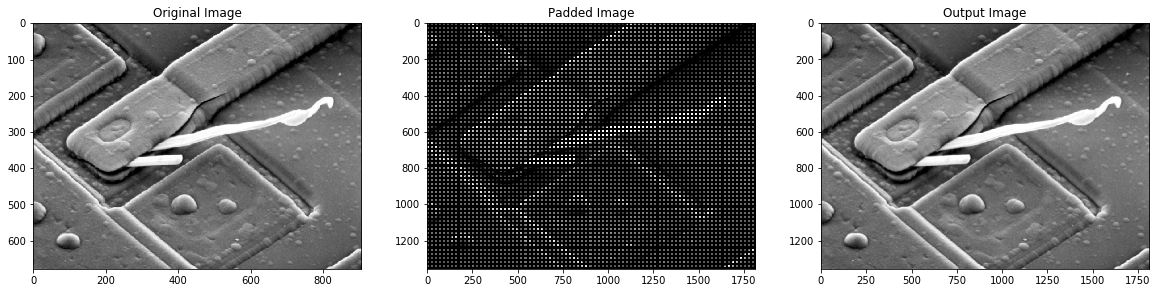

In [32]:
plt.figure(figsize=(20,15))
plt.gray()
plt.subplot(1,3,1)
plt.imshow(im)
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(im1)
plt.title('Padded Image')
plt.subplot(1,3,3)
plt.imshow(im2.real) # the imaginary part is an artifact
plt.title('Output Image')
plt.show()

<h2>Using the inverse filter to restore a motion-blurred image</h2>

1. First create a motion blur kernel of a given shape.
2. Convolve the kernel with an input image in the frequency domain.
3. Get the motion-blurred image in the spatial domain with IDFT.
4. Compute the inverse filter kernel and convolve with the blurred image in the frequency domain.
4. Get the convolved image back in the spatial domain.
5. Plot all the images and kernels in the frequency domain.

In [33]:
im = img

<h3>Create the motion blur kernel</h3>

In [34]:
size = 21
kernel = np.zeros((size, size))
kernel[int((size-1)/2), :] = np.ones(size)
kernel = kernel / size
kernel = np.pad(kernel, (((im.shape[0]-size)//2,(im.shape[0]-size)//2+1), ((im.shape[1]-size)//2,(im.shape[1]-size)//2+1)), padwithzeros)

In [35]:
freq = fp.fft2(im)
freq_kernel = fp.fft2(fp.ifftshift(kernel))
convolved1 = freq*freq_kernel
im_blur = fp.ifft2(convolved1).real
im_blur = im_blur / np.max(im_blur)

In [36]:
epsilon = 10**-6

In [37]:
freq = fp.fft2(im_blur)
freq_kernel = 1 / (epsilon + freq_kernel)

In [38]:
convolved = freq*freq_kernel
im_restored = fp.ifft2(convolved).real
im_restored = im_restored / np.max(im_restored)

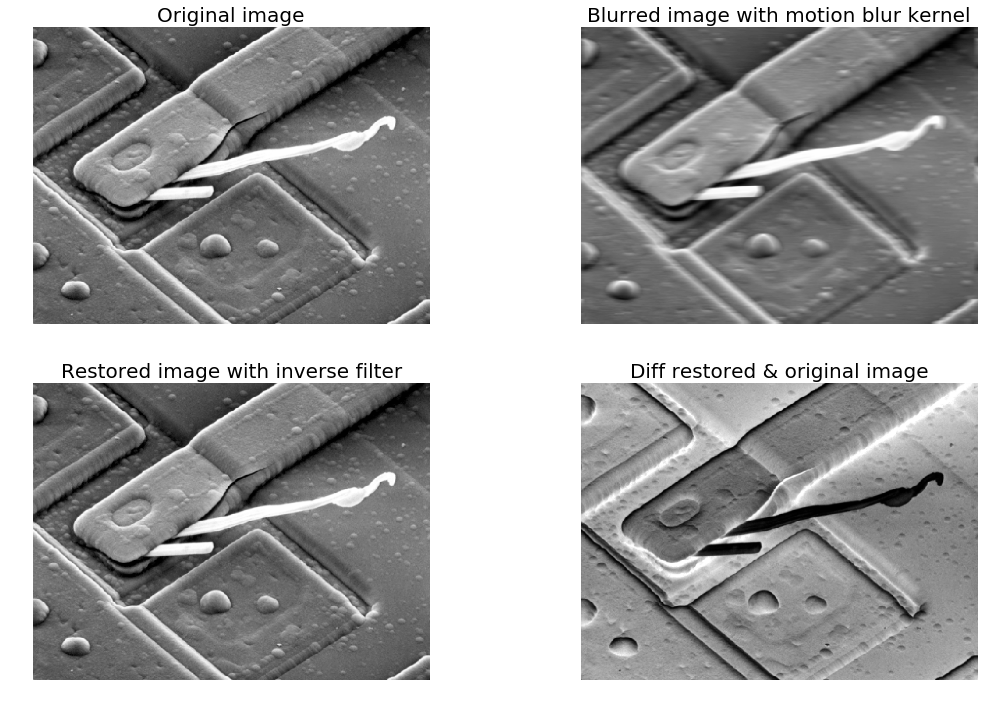

In [39]:
plt.figure(figsize=(18,12))
plt.subplot(221)
plt.imshow(im)
plt.title('Original image', size=20)
plt.axis('off')
plt.subplot(222)
plt.imshow(im_blur)
plt.title('Blurred image with motion blur kernel', size=20)
plt.axis('off')
plt.subplot(223)
plt.imshow(im_restored)
plt.title('Restored image with inverse filter', size=20)
plt.axis('off')
plt.subplot(224)
plt.imshow(im_restored - im)
plt.title('Diff restored & original image', size=20)
plt.axis('off')
plt.show()